### 1. 라이브러리

In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import json_normalize
import json
import requests
from tqdm import tqdm

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, RepeatVector, Input, LSTM, concatenate, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers import TimeDistributed, Reshape

### 2. 모델 분석

#### 2.1. 정형 데이터에 대한 RNN
바람지도 데이터를 사용하기에 앞서서 정형 데이터만 가지고 학습을 할 수 있는지 RNN을 만들어본다.

##### 2.1.1. 데이터 정리
EDA 과정을 통해 얻어낸 중간 전처리된 데이터를 불러오고, 지난 분석에서 유의미하지 못했던 교통량 데이터를 새로운 데이터로 바꾼다.

In [3]:
# EDA 과정에서 완성된 데이터 불러오기
df_final_2022 = pd.read_csv('./df_final_2022.csv')
df_final_2022

,일시,미세먼지(PM10),초미세먼지(PM2.5),기온,강수량,풍속,풍향,습도,증기압,이슬점온도,...,전운량,중하층운량,운형,시정,지면온도,5cm 지중온도,10cm 지중온도,20cm 지중온도,30cm 지중온도,교통량
0,2022-01-01 00:00:00,20.0,8.0,-8.5,0.0,1.9,320,41,1.3,-19.4,...,0,0,0,2000,-7.0,-1.0,-1.0,-0.2,1.0,169363
1,2022-01-01 01:00:00,22.0,10.0,-9.2,0.0,1.8,270,42,1.3,-19.7,...,0,0,0,2000,-7.2,-1.1,-1.1,-0.2,1.0,160918
2,2022-01-01 02:00:00,21.0,9.0,-9.5,0.0,1.2,270,43,1.3,-19.7,...,0,0,0,2000,-7.5,-1.3,-1.2,-0.2,1.0,89429
3,2022-01-01 03:00:00,20.0,9.0,-9.3,0.0,1.4,290,46,1.4,-18.8,...,0,0,0,2000,-7.6,-1.4,-1.2,-0.2,1.0,65262
4,2022-01-01 04:00:00,20.0,9.0,-9.6,0.0,1.7,340,48,1.4,-18.5,...,0,0,0,2000,-7.6,-1.4,-1.3,-0.3,1.0,66400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31 19:00:00,55.0,42.0,-0.2,0.0,1.8,20,73,4.4,-4.4,...,0,0,0,1211,-0.9,-0.1,-0.5,-0.5,0.6,309829
8756,2022-12-31 20:00:00,56.0,43.0,-0.8,0.0,1.4,20,75,4.3,-4.6,...,4,2,0,1171,-1.8,-0.1,-0.5,-0.5,0.6,309450
8757,2022-12-31 21:00:00,56.0,44.0,-1.0,0.0,0.9,340,77,4.4,-4.5,...,7,7,Sc,1134,-2.8,-0.2,-0.5,-0.5,0.6,311735
8758,2022-12-31 22:00:00,58.0,45.0,-0.8,0.0,0.5,290,78,4.5,-4.1,...,8,8,0,1094,-2.2,-0.3,-0.5,-0.5,0.6,283063


In [7]:
# 날짜를 받아 새로운 CO(배기가스 배출량) 데이터를 추가로 수집하는 함수
# http://data.seoul.go.kr/dataList/OA-2221/S/1/datasetView.do
def get_co_series(date):
    service_key = '7179534268616e6633385067787468'
    service_url = 'http://openAPI.seoul.go.kr:8088/'
    service_param = f'{service_key}/json/TimeAverageCityAir/0/999/{date}'
    url = service_url + service_param
    response = requests.get(url)
    contents = response.text
    info = json.loads(contents)
    df_co_daily = json_normalize(info['TimeAverageCityAir']['row']).rename({'MSRDT':'일시'}, axis=1)
    df_co_daily = df_co_daily.groupby('일시')['CO'].mean()
    df_co_daily.index = pd.to_datetime(df_co_daily.index, format='%Y%m%d%H%M')
    return df_co_daily

In [13]:
# 날짜를 기준으로 데이터를 반복적으로 불러와서 합치기
start_date = '202201010000'
end_date = '202212312300'
date_list = pd.date_range(start=start_date, end=end_date, freq='H').strftime('%Y%m%d%H%M').tolist()
 
df_combined = pd.DataFrame()
for dt in date_list:
  df_combined = pd.concat([df_combined, get_co_series(dt)])
df_combined.columns = ['CO (ppm)']
df_combined

ConnectionError: HTTPConnectionPool(host='openapi.seoul.go.kr', port=8088): Max retries exceeded with url: /7179534268616e6633385067787468/json/TimeAverageCityAir/0/999/202205230300 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001D17C2B9B20>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond'))

In [17]:
df_combined = df_combined[:-3]
df_combined

,0
2022-01-01 00:00:00,0.404
2022-01-01 01:00:00,0.464
2022-01-01 02:00:00,0.468
2022-01-01 03:00:00,0.476
2022-01-01 04:00:00,0.480
...,...
2022-05-22 19:00:00,0.384
2022-05-22 20:00:00,0.404
2022-05-22 21:00:00,0.420
2022-05-22 22:00:00,0.416


In [18]:
# 중간에 끊겼다. 뒤에만 다시 돌려서 합치기
start_date = '202205230000'
end_date = '202212312300'
date_list = pd.date_range(start=start_date, end=end_date, freq='H').strftime('%Y%m%d%H%M').tolist()
 
for dt in date_list:
  df_combined = pd.concat([df_combined, get_co_series(dt)])
df_combined.columns = ['CO (ppm)']
df_combined

,CO (ppm)
2022-01-01 00:00:00,0.404
2022-01-01 01:00:00,0.464
2022-01-01 02:00:00,0.468
2022-01-01 03:00:00,0.476
2022-01-01 04:00:00,0.480
...,...
2022-12-31 19:00:00,0.892
2022-12-31 20:00:00,0.968
2022-12-31 21:00:00,1.048
2022-12-31 22:00:00,1.096


In [26]:
# 이를 앞서 완성된 데이터와 합쳐주기 위해 전처리
# 참고: df_dust_2022의 dust는 잘못된 변수 이름 설정이다. 본래는 CO가 맞다.
df_dust_2022 = df_combined.reset_index().rename({'index':'일시'}, axis=1)
df_dust_2022['일시'] = pd.to_datetime(df_dust_2022['일시'], format='%Y-%m-%d %H:%M:%S')
df_dust_2022

,일시,CO (ppm)
0,2022-01-01 00:00:00,0.404
1,2022-01-01 01:00:00,0.464
2,2022-01-01 02:00:00,0.468
3,2022-01-01 03:00:00,0.476
4,2022-01-01 04:00:00,0.480
...,...,...
8755,2022-12-31 19:00:00,0.892
8756,2022-12-31 20:00:00,0.968
8757,2022-12-31 21:00:00,1.048
8758,2022-12-31 22:00:00,1.096


In [33]:
# 결측치 확인
df_dust_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   일시        8760 non-null   datetime64[ns]
 1   CO (ppm)  8760 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 137.0 KB


In [34]:
# 데이터 합쳐주기
df_final_2022['일시'] = pd.to_datetime(df_final_2022['일시'], format='%Y-%m-%d %H:%M:%S')
df_real_final_2022 = pd.merge(df_final_2022, df_dust_2022, on='일시', how='left')
df_real_final_2022

,일시,미세먼지(PM10),초미세먼지(PM2.5),기온,강수량,풍속,풍향,습도,증기압,이슬점온도,...,중하층운량,운형,시정,지면온도,5cm 지중온도,10cm 지중온도,20cm 지중온도,30cm 지중온도,교통량,CO (ppm)
0,2022-01-01 00:00:00,20.0,8.0,-8.5,0.0,1.9,320,41,1.3,-19.4,...,0,0,2000,-7.0,-1.0,-1.0,-0.2,1.0,169363,0.404
1,2022-01-01 01:00:00,22.0,10.0,-9.2,0.0,1.8,270,42,1.3,-19.7,...,0,0,2000,-7.2,-1.1,-1.1,-0.2,1.0,160918,0.464
2,2022-01-01 02:00:00,21.0,9.0,-9.5,0.0,1.2,270,43,1.3,-19.7,...,0,0,2000,-7.5,-1.3,-1.2,-0.2,1.0,89429,0.468
3,2022-01-01 03:00:00,20.0,9.0,-9.3,0.0,1.4,290,46,1.4,-18.8,...,0,0,2000,-7.6,-1.4,-1.2,-0.2,1.0,65262,0.476
4,2022-01-01 04:00:00,20.0,9.0,-9.6,0.0,1.7,340,48,1.4,-18.5,...,0,0,2000,-7.6,-1.4,-1.3,-0.3,1.0,66400,0.480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31 19:00:00,55.0,42.0,-0.2,0.0,1.8,20,73,4.4,-4.4,...,0,0,1211,-0.9,-0.1,-0.5,-0.5,0.6,309829,0.892
8756,2022-12-31 20:00:00,56.0,43.0,-0.8,0.0,1.4,20,75,4.3,-4.6,...,2,0,1171,-1.8,-0.1,-0.5,-0.5,0.6,309450,0.968
8757,2022-12-31 21:00:00,56.0,44.0,-1.0,0.0,0.9,340,77,4.4,-4.5,...,7,Sc,1134,-2.8,-0.2,-0.5,-0.5,0.6,311735,1.048
8758,2022-12-31 22:00:00,58.0,45.0,-0.8,0.0,0.5,290,78,4.5,-4.1,...,8,0,1094,-2.2,-0.3,-0.5,-0.5,0.6,283063,1.096


In [35]:
# 상관관계가 매우 낮았던 교통량 데이터 삭제
df_real_final_2022.drop(['교통량'], axis=1, inplace=True)
df_real_final_2022

,일시,미세먼지(PM10),초미세먼지(PM2.5),기온,강수량,풍속,풍향,습도,증기압,이슬점온도,...,전운량,중하층운량,운형,시정,지면온도,5cm 지중온도,10cm 지중온도,20cm 지중온도,30cm 지중온도,CO (ppm)
0,2022-01-01 00:00:00,20.0,8.0,-8.5,0.0,1.9,320,41,1.3,-19.4,...,0,0,0,2000,-7.0,-1.0,-1.0,-0.2,1.0,0.404
1,2022-01-01 01:00:00,22.0,10.0,-9.2,0.0,1.8,270,42,1.3,-19.7,...,0,0,0,2000,-7.2,-1.1,-1.1,-0.2,1.0,0.464
2,2022-01-01 02:00:00,21.0,9.0,-9.5,0.0,1.2,270,43,1.3,-19.7,...,0,0,0,2000,-7.5,-1.3,-1.2,-0.2,1.0,0.468
3,2022-01-01 03:00:00,20.0,9.0,-9.3,0.0,1.4,290,46,1.4,-18.8,...,0,0,0,2000,-7.6,-1.4,-1.2,-0.2,1.0,0.476
4,2022-01-01 04:00:00,20.0,9.0,-9.6,0.0,1.7,340,48,1.4,-18.5,...,0,0,0,2000,-7.6,-1.4,-1.3,-0.3,1.0,0.480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31 19:00:00,55.0,42.0,-0.2,0.0,1.8,20,73,4.4,-4.4,...,0,0,0,1211,-0.9,-0.1,-0.5,-0.5,0.6,0.892
8756,2022-12-31 20:00:00,56.0,43.0,-0.8,0.0,1.4,20,75,4.3,-4.6,...,4,2,0,1171,-1.8,-0.1,-0.5,-0.5,0.6,0.968
8757,2022-12-31 21:00:00,56.0,44.0,-1.0,0.0,0.9,340,77,4.4,-4.5,...,7,7,Sc,1134,-2.8,-0.2,-0.5,-0.5,0.6,1.048
8758,2022-12-31 22:00:00,58.0,45.0,-0.8,0.0,0.5,290,78,4.5,-4.1,...,8,8,0,1094,-2.2,-0.3,-0.5,-0.5,0.6,1.096


In [37]:
# 새로운 데이터와 미세먼지 상관계수 확인
df_real_final_2022[['미세먼지(PM10)', 'CO (ppm)']].corr()['미세먼지(PM10)'].sort_values(ascending=False)

미세먼지(PM10)    1.000000
CO (ppm)      0.517536
Name: 미세먼지(PM10), dtype: float64

In [38]:
# 매우 상관계수가 높다. 살짝 시간차가 있는 것을 고려하면 매우 상관 관계가 있을 것으로 생각된다.
# 최종 데이터 저장
df_real_final_2022.to_csv('./df_real_final_2022.csv', index=False)

##### 2.1.2. RNN 모델 학습을 위한 데이터 전처리
RNN 학습이 가능한 꼴로 데이터를 다시 전처리 해준다.

In [11]:
# 2.1.1.에서 완성된 데이터 불러오기
df_real_final_2022 = pd.read_csv('./df_real_final_2022.csv')
df_real_final_2022

,일시,미세먼지(PM10),초미세먼지(PM2.5),기온,강수량,풍속,풍향,습도,증기압,이슬점온도,...,전운량,중하층운량,운형,시정,지면온도,5cm 지중온도,10cm 지중온도,20cm 지중온도,30cm 지중온도,CO (ppm)
0,2022-01-01 00:00:00,20.0,8.0,-8.5,0.0,1.9,320,41,1.3,-19.4,...,0,0,0,2000,-7.0,-1.0,-1.0,-0.2,1.0,0.404
1,2022-01-01 01:00:00,22.0,10.0,-9.2,0.0,1.8,270,42,1.3,-19.7,...,0,0,0,2000,-7.2,-1.1,-1.1,-0.2,1.0,0.464
2,2022-01-01 02:00:00,21.0,9.0,-9.5,0.0,1.2,270,43,1.3,-19.7,...,0,0,0,2000,-7.5,-1.3,-1.2,-0.2,1.0,0.468
3,2022-01-01 03:00:00,20.0,9.0,-9.3,0.0,1.4,290,46,1.4,-18.8,...,0,0,0,2000,-7.6,-1.4,-1.2,-0.2,1.0,0.476
4,2022-01-01 04:00:00,20.0,9.0,-9.6,0.0,1.7,340,48,1.4,-18.5,...,0,0,0,2000,-7.6,-1.4,-1.3,-0.3,1.0,0.480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31 19:00:00,55.0,42.0,-0.2,0.0,1.8,20,73,4.4,-4.4,...,0,0,0,1211,-0.9,-0.1,-0.5,-0.5,0.6,0.892
8756,2022-12-31 20:00:00,56.0,43.0,-0.8,0.0,1.4,20,75,4.3,-4.6,...,4,2,0,1171,-1.8,-0.1,-0.5,-0.5,0.6,0.968
8757,2022-12-31 21:00:00,56.0,44.0,-1.0,0.0,0.9,340,77,4.4,-4.5,...,7,7,Sc,1134,-2.8,-0.2,-0.5,-0.5,0.6,1.048
8758,2022-12-31 22:00:00,58.0,45.0,-0.8,0.0,0.5,290,78,4.5,-4.1,...,8,8,0,1094,-2.2,-0.3,-0.5,-0.5,0.6,1.096


In [40]:
# 일시를 datetime으로 변환
df_real_final_2022['일시'] = pd.to_datetime(df_real_final_2022['일시'], format='%Y-%m-%d %H:%M:%S')
df_real_final_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   일시            8760 non-null   datetime64[ns]
 1   미세먼지(PM10)    8760 non-null   float64       
 2   초미세먼지(PM2.5)  8760 non-null   float64       
 3   기온            8760 non-null   float64       
 4   강수량           8760 non-null   float64       
 5   풍속            8760 non-null   float64       
 6   풍향            8760 non-null   int64         
 7   습도            8760 non-null   int64         
 8   증기압           8760 non-null   float64       
 9   이슬점온도         8760 non-null   float64       
 10  현지기압          8760 non-null   float64       
 11  해면기압          8760 non-null   float64       
 12  적설            8760 non-null   float64       
 13  전운량           8760 non-null   int64         
 14  중하층운량         8760 non-null   int64         
 15  운형            8760 non-null   object  

In [12]:
data = df_real_final_2022.copy()
data.set_index('일시', inplace=True)  # '일시'를 index로 설정

# categorical 데이터인 운형 데이터는 one-hot encoding 적용
encoder = OneHotEncoder(sparse_output=False)
cloud_form_encoded = encoder.fit_transform(data[['운형']])
cloud_form_encoded_df = pd.DataFrame(cloud_form_encoded, columns=encoder.get_feature_names_out(['운형']), index=data.index)
data_encoded = pd.concat([data.drop('운형', axis=1), cloud_form_encoded_df], axis=1)

In [13]:
# 확인차 결측치 처리
data_encoded.fillna(data_encoded.median(), inplace=True)

# targets 설정
targets = data_encoded[['미세먼지(PM10)', '초미세먼지(PM2.5)']]

# features 설정
features = data_encoded.drop(['미세먼지(PM10)', '초미세먼지(PM2.5)'], axis=1)

In [14]:
# scaling 적용
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_features

array([[0.10547667, 0.        , 0.21590909, ..., 0.        , 0.        ,
        0.        ],
       [0.09127789, 0.        , 0.20454545, ..., 0.        , 0.        ,
        0.        ],
       [0.0851927 , 0.        , 0.13636364, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.25760649, 0.        , 0.10227273, ..., 0.        , 0.        ,
        0.        ],
       [0.26166329, 0.        , 0.05681818, ..., 0.        , 0.        ,
        0.        ],
       [0.27383367, 0.        , 0.14772727, ..., 0.        , 0.        ,
        0.        ]])

In [15]:
# ndarray로 변환
X = np.array(scaled_features)
y = np.array(targets)

# 시계열 데이터에서 부분 시계열을 얻기 위해 사용하는 함수
def create_sequences(X, y, n_steps):
    Xs, ys = [], []
    for i in range(len(X) - n_steps):
        Xs.append(X[i:i+n_steps])
        ys.append(y[i+n_steps])
    return np.array(Xs), np.array(ys)

# 이전에 고려할 시계열의 길이
n_steps = 24

# 데이터를 고려할 시계열의 길이로 자르기
X_seq, y_seq = create_sequences(X, y, n_steps)

# train, test 데이터 분리
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

##### 2.1.3. model 1
- input: 이전 24시간의 기상정보 데이터, CO 데이터
- output: 바로 다음 미세먼지, 초미세먼지의 값을 예측
- 특징: 가장 기본적인 RNN 모델, 그냥 예측 가능성을 확인하기 위한 용도로 학습

In [58]:
# 간단한 RNN으로 시도
model1 = Sequential()
model1.add(SimpleRNN(50, activation='relu', input_shape=(n_steps, 55)))
model1.add(Dropout(0.2))
model1.add(Dense(2))

model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model1.summary()

history1 = model1.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_data=(X_test_seq, y_test_seq), verbose=1)

test_loss1, test_mae1 = model1.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {test_loss1}, Test MAE: {test_mae1}")


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 50)                5300      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 


 dense_2 (Dense)             (None, 2)                 102       
                                                                 
Total params: 5402 (21.10 KB)
Trainable params: 5402 (21.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
219/219 [==============================] - 2s 5ms/step - loss: 335.7713 - mae: 11.8391 - val_loss: 225.0369 - val_mae: 10.1116
Epoch 2/50
219/219 [==============================] - 1s 4ms/step - loss: 230.9403 - mae: 9.4917 - val_loss: 244.9274 - val_mae: 9.4814
Epoch 3/50
219/219 [==============================] - 1s 4ms/step - loss: 214.2882 - mae: 9.0300 - val_loss: 180.9235 - val_mae: 8.1364
Epoch 4/50
219/219 [==============================] - 1s 4ms/step - loss: 197.8538 - mae: 8.5681 - val_loss: 291.2834 - val_mae: 10.8418
Epoch 5/50
219/219 [==============================] - 1s 4ms/step - loss: 197.7707 - mae: 8.6827 - val_loss: 181.8912 - val_mae: 9.1190
Epoch 6/50
219/219 

In [31]:
# 학습 곡선 시각화를 위한 함수
def plot_loss_curve(history):
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()


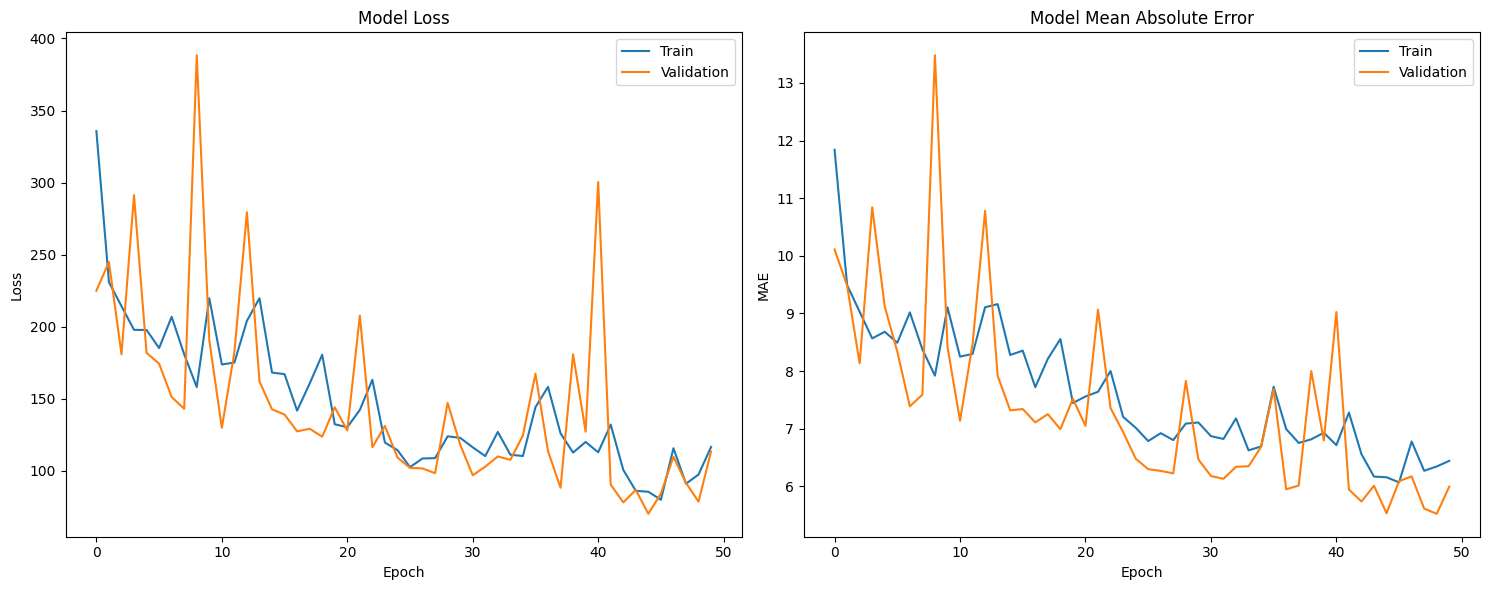

In [60]:
# model 1의 학습곡선
plot_loss_curve(history1)

분석: 학습의 가능성을 확인했다. loss 113.5, mae 5.996 정도로 꽤 괜찮은 수준으로 생각된다. 과적합은 관측되지 않는 정도의 epoch이므로 EarlyStopping을 추가하여 과적합이 되기 전 최적의 모델을 확인해보자.

##### 2.1.4. model 2
- input: 이전 24시간의 기상정보 데이터, CO 데이터
- output: 바로 다음 미세먼지, 초미세먼지의 값을 예측
- 특징: 학습의 정도를 제대로 판단하기 위해 EarlyStopping을 추가하고, 큰 epoch로 학습해본다.

In [65]:
# EarlyStopping 적용
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model2 = Sequential()
model2.add(SimpleRNN(50, activation='relu', input_shape=(n_steps, 55)))
model2.add(Dropout(0.2))
model2.add(Dense(2))
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model2.summary()

history2 = model2.fit(
    X_train_seq, y_train_seq,
    epochs=150,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stopping_callback],
    verbose=1
)

test_loss2, test_mae2 = model2.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {test_loss2}, Test MAE: {test_mae2}")


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 simple_rnn_6 (SimpleRNN)    (None, 50)                5300      
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 2)                 102       
                                                                 
Total params: 5402 (21.10 KB)
Trainable params: 5402 (21.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/150
219/219 [==============================] - 2s 5ms/step - loss: 392.2784 - mae: 13.0233 - val_loss: 205.4279 - val_mae: 8.9225
Epoch 2/150
219/219 [==============================] - 1s 4ms/step - loss: 233.0078 - mae: 9.4563 - val_loss: 213.0263 - val_mae: 8.5470
Epoch 3/150
219/219 [==============================] - 1s 4ms/step - loss: 231.8558 - mae: 9.3599 - val_loss: 185.6951 - val_mae: 8.4824
Epoch 4/150
219/219 [=====

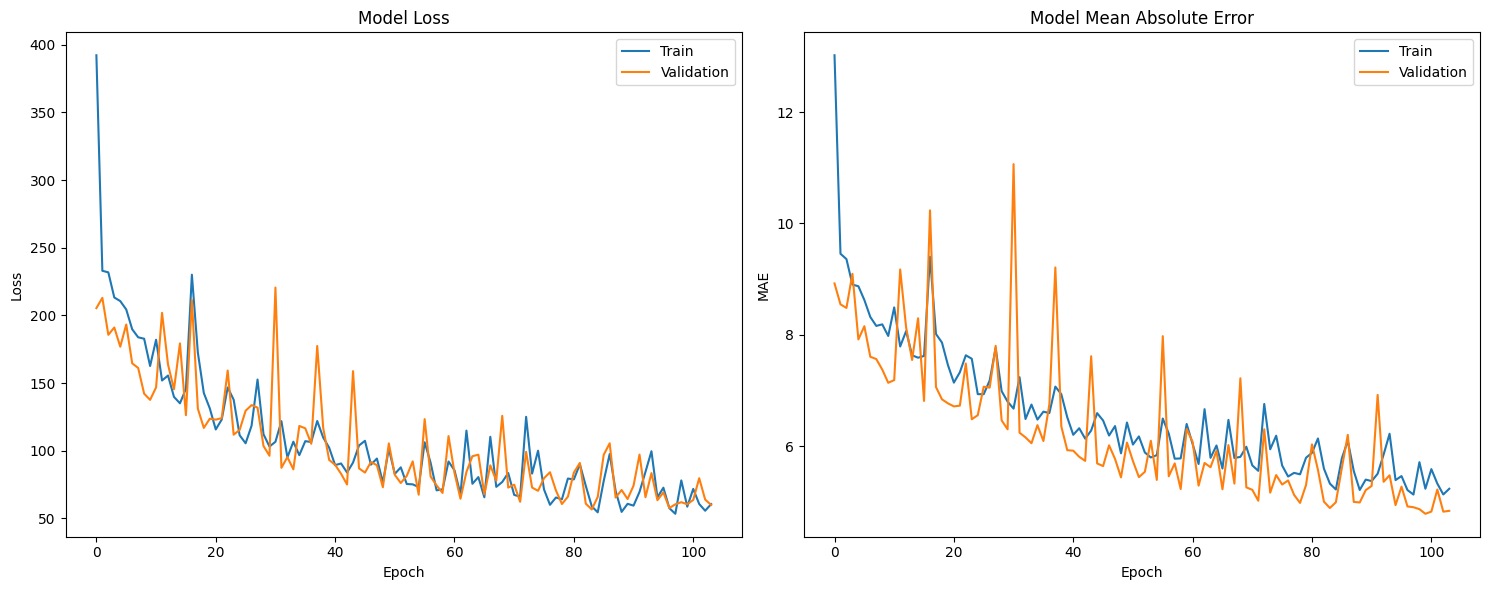

In [66]:
# model 2의 학습 곡선
plot_loss_curve(history2)

분석: 학습이 꽤 잘된다는 것을 알 수 있다. 하지만 예상했듯이 이 모델은 하루의 기상정보 데이터, CO 데이터를 받아 바로 직후의 미세먼지, 초미세먼지 예측 데이터를 내놓을 뿐이고, 이는 아무 소용이 없다. 원하는 것은 이전의 여러 시간대의 데이터를 종합적으로 비교하는 것을 통해 데이터를 예측하는 것이다.

##### 2.1.5. model 3
- input: 이전 일주일의 기상정보, CO 데이터
- output: 바로 다음 미세먼지, 초미세먼지의 값을 예측
- 특징: 본격적으로 원하는 기능의 모델을 구현하는 것을 시도한다. LSTM을 사용한 형태의 모델로 긴 기간의 데이터도 잘 분석할 수 있도록 한다. EDA 과정에서 일년단위의 계절적인 특징 뿐만 아니라 주, 일 단위의 주기성이 나타난다는 것을 알 수 있었는데, 기상정보 데이터 등이 계절에 관한 정보를 가지고 있으므로 주 단위로 부분 시계열을 잡아 미세먼지, 초미세먼지를 예측하는 것이 전체적인 주기성을 반영하기에 충분할 것이라고 생각했다.

In [88]:
# 주 단위로 시계열을 다시 자른다.
n_steps = 24*7
X_seq, y_seq = create_sequences(X, y, n_steps)
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# LSTM 모델로 학습한다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model3 = Sequential()
model3.add(LSTM(50, input_shape=(n_steps, 55)))
model3.add(Dense(2))
model3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model3.summary()

history3 = model3.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stopping_callback],
    verbose=1
)

test_loss3, test_mae3 = model3.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {test_loss3}, Test MAE: {test_mae3}")


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 50)                21200     
                                                                 
 dense_17 (Dense)            (None, 2)                 102       
                                                                 
Total params: 21302 (83.21 KB)
Trainable params: 21302 (83.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
215/215 [==============================] - 11s 46ms/step - loss: 668.7681 - mae: 17.6717 - val_loss: 422.6470 - val_mae: 13.3432
Epoch 2/50
215/215 [==============================] - 11s 50ms/step - loss: 420.2127 - mae: 12.5487 - val_loss: 321.4680 - val_mae: 11.7116
Epoch 3/50
215/215 [==============================] - 11s 50ms/step - loss: 358.9780 - mae: 11.8201 - val_loss: 296.4158 - val_mae: 1

In [107]:
# 모델 저장
model3.save('model3.h5')

c:\Users\idfor\miniconda3\envs\ML\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


분석: 확실히 일 단위로 자른 간단한 RNN을 쓸때보다 개선이 되었다고 생각된다. 하지만 여전히 4 근처에서 수렴하므로 바람지도 데이터가 이를 개선할 것이라고 기대한다.

#### 2.2. 바람데이터에 대한 CNN
정형 데이터로 학습을 진행했으니, 이제 바람지도 데이터를 다루어서 CNN을 만들어 본다.

##### 2.2.1. model 4
- input: 현재 바람지도 데이터
- output: 현재 미세먼지, 초미세먼지의 값을 예측
- 특징: 바람지도 데이터를 통해 미세먼지, 초미세먼지 데이터를 유의미하게 예측할 수 있는지 확인하기 위한 실험과도 같은 단계이다. 먼저, 기본적인 CNN 구조를 적용해본다.

In [112]:
image_directory = './windmap/'
image_size = (128, 128)

# 바람지도 데이터를 날짜별로 따로 불러와서 병합하는 함수
def load_images_and_labels(df, image_dir, size):
    images = []
    labels = []
    for _, row in df.iterrows():
        filename = row['일시'].strftime('%Y%m%d%H') + '.png'
        img_path = os.path.join(image_dir, filename)
        if os.path.exists(img_path):
            img = load_img(img_path, target_size=size)
            img_array = img_to_array(img)
            img_array = img_array / 255.0
            images.append(img_array)
            labels.append([row['미세먼지(PM10)'], row['초미세먼지(PM2.5)']])
    return np.array(images), np.array(labels)

# 데이터 확인
X, y = load_images_and_labels(df_real_final_2022, image_directory, image_size)
X, y

(array([[[[0.17254902, 0.4509804 , 0.50980395],
          [0.16470589, 0.43529412, 0.5058824 ],
          [0.16470589, 0.43529412, 0.5058824 ],
          ...,
          [0.10588235, 0.35686275, 0.4627451 ],
          [0.10588235, 0.34117648, 0.4745098 ],
          [0.10588235, 0.3254902 , 0.48235294]],
 
         [[0.10588235, 0.3764706 , 0.44705883],
          [0.1882353 , 0.4509804 , 0.5372549 ],
          [0.10588235, 0.3647059 , 0.45490196],
          ...,
          [0.10588235, 0.40784314, 0.41960785],
          [0.10588235, 0.39215687, 0.43137255],
          [0.10588235, 0.38039216, 0.44313726]],
 
         [[0.1254902 , 0.39215687, 0.47058824],
          [0.10588235, 0.3647059 , 0.45490196],
          [0.1764706 , 0.43137255, 0.5294118 ],
          ...,
          [0.24705882, 0.5882353 , 0.5176471 ],
          [0.6666667 , 0.7921569 , 0.7764706 ],
          [0.1882353 , 0.49411765, 0.4745098 ]],
 
         ...,
 
         [[0.10588235, 0.20784314, 0.5294118 ],
          [0.10588

In [108]:
# 모델 정의 및 학습(Dropout을 사용하지 않은 CNN 모델)
input_shape = (128, 128, 3)
output_size = 2

model4 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(output_size, activation='linear')
])

model4.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model4.summary()

history4 = model4.fit(X, y, batch_size=32, epochs=10, validation_split=0.2)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 64)      

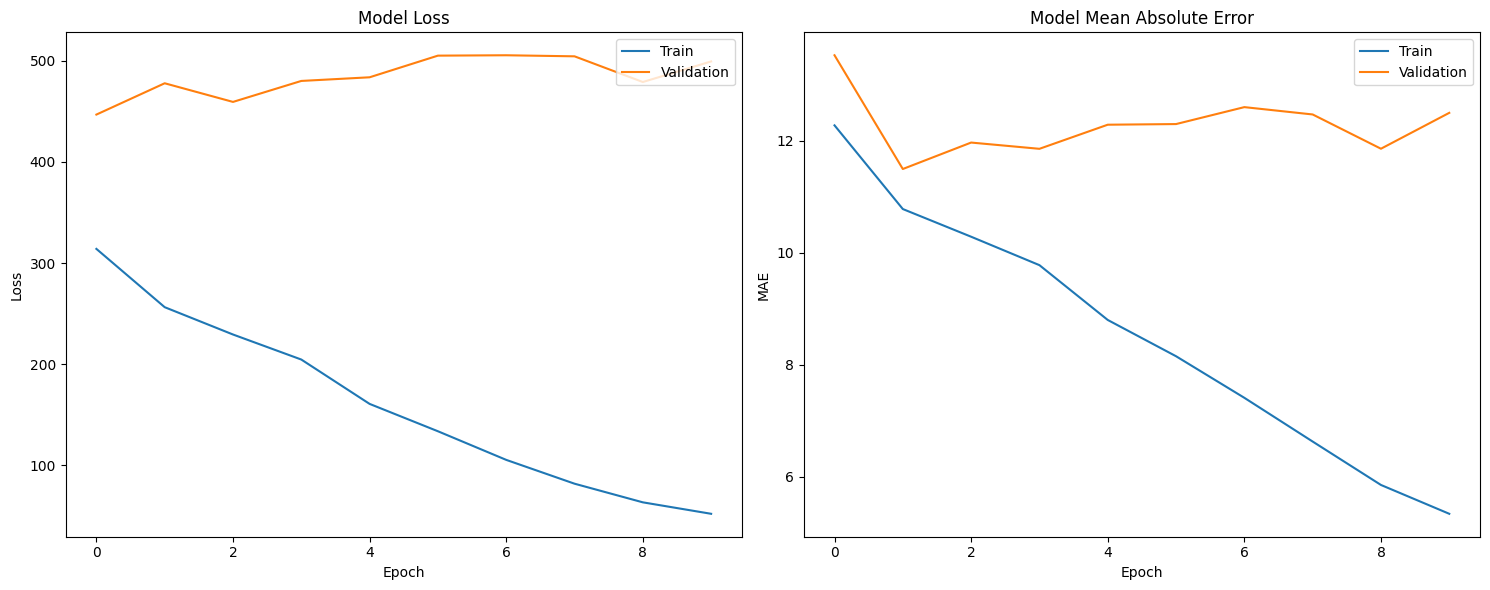

In [109]:
# 학습 곡선 확인
plot_loss_curve(history4)

In [106]:
# 모델 저장
model4.save('model4.h5')

c:\Users\idfor\miniconda3\envs\ML\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


분석: 완벽한 과적합 곡선이다. 이는 바람지도 데이터 만으로는 전혀 미세먼지 예측이 어려울 것 같다는 생각이 들게 한다. 이는 예상과 맞는 결과이지만, 혹시 모르니 과적합 해소를 위한 기법들을 추가해본다.

##### 2.2.2 model 5
- input: 현재 바람지도 데이터
- output: 현재 미세먼지, 초미세먼지의 값을 예측
- 특징: 혹시 모르니 다른 모델로 시도해보는 과정이다. 과적합이 의심되니 Dropout을 추가하고, 모델의 크기를 줄여본다.

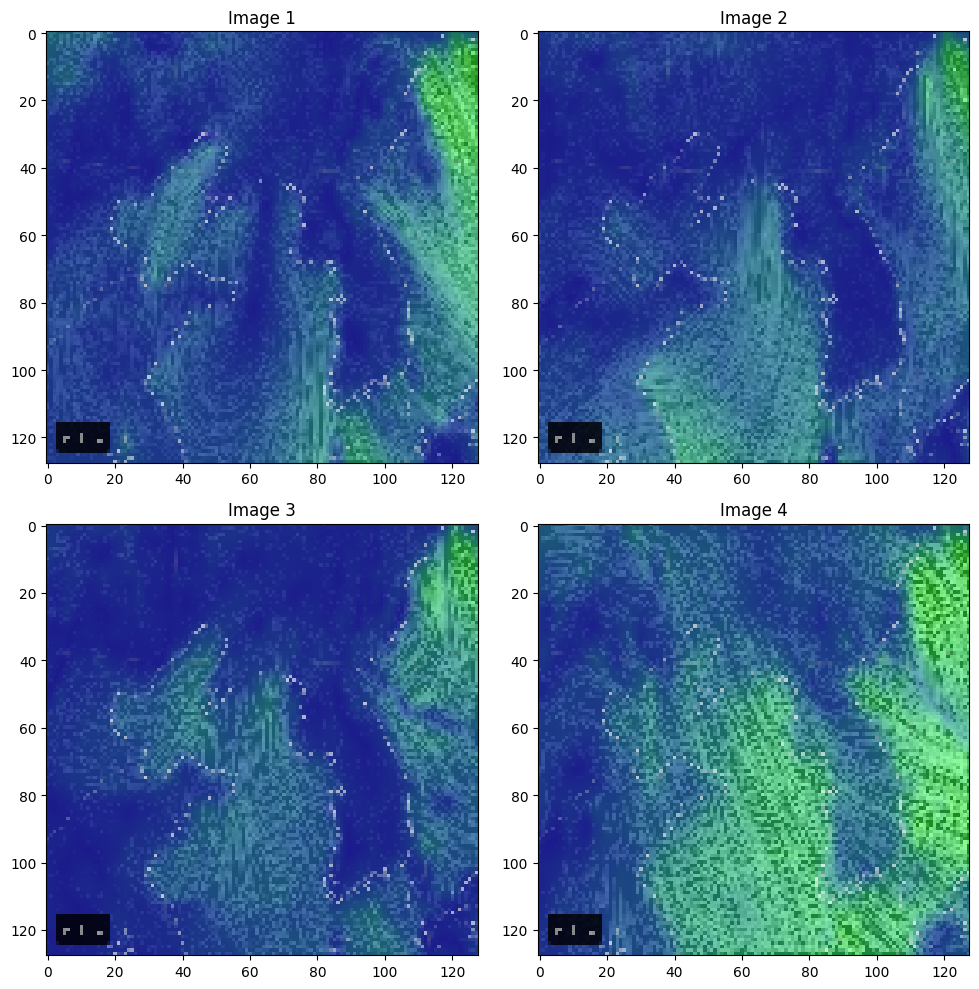

In [113]:
# 먼저, 학습에 사용되는 데이터를 시각화해본다.
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(X[0])
axs[0, 0].set_title('Image 1')

axs[0, 1].imshow(X[100])
axs[0, 1].set_title('Image 2')

axs[1, 0].imshow(X[200])
axs[1, 0].set_title('Image 3')

axs[1, 1].imshow(X[300])
axs[1, 1].set_title('Image 4')

plt.tight_layout()
plt.show()


In [115]:
# 바람 데이터의 화질이 매우 낮아서 학습이 어려웠던 것일 수 있을 것으로 생각된다.
# 바람 데이터를 화질을 높여 다시 불러온다.
image_directory = './windmap/'
image_size = (256, 256)

def load_images_and_labels(df, image_dir, size):
    images = []
    labels = []
    for _, row in df.iterrows():
        filename = row['일시'].strftime('%Y%m%d%H') + '.png'
        img_path = os.path.join(image_dir, filename)
        if os.path.exists(img_path):
            img = load_img(img_path, target_size=size)
            img_array = img_to_array(img)
            img_array = img_array / 255.0
            images.append(img_array)
            labels.append([row['미세먼지(PM10)'], row['초미세먼지(PM2.5)']])
    return np.array(images), np.array(labels)

X_new, y_new = load_images_and_labels(df_real_final_2022, image_directory, image_size)
X_new, y_new

(array([[[[0.10588235, 0.38431373, 0.4392157 ],
          [0.13333334, 0.4117647 , 0.47058824],
          [0.10588235, 0.3764706 , 0.44705883],
          ...,
          [0.10588235, 0.3254902 , 0.48235294],
          [0.10588235, 0.3137255 , 0.4862745 ],
          [0.10588235, 0.30980393, 0.49019608]],
 
         [[0.15294118, 0.43137255, 0.49019608],
          [0.10588235, 0.38039216, 0.44313726],
          [0.12941177, 0.4       , 0.47058824],
          ...,
          [0.12156863, 0.36078432, 0.4862745 ],
          [0.10588235, 0.3372549 , 0.4745098 ],
          [0.18039216, 0.40784314, 0.5529412 ]],
 
         [[0.10588235, 0.38039216, 0.44313726],
          [0.11764706, 0.3882353 , 0.45882353],
          [0.10588235, 0.37254903, 0.44705883],
          ...,
          [0.21176471, 0.4745098 , 0.5568628 ],
          [0.10588235, 0.36078432, 0.45882353],
          [0.10588235, 0.3529412 , 0.4627451 ]],
 
         ...,
 
         [[0.10588235, 0.21176471, 0.5294118 ],
          [0.10588

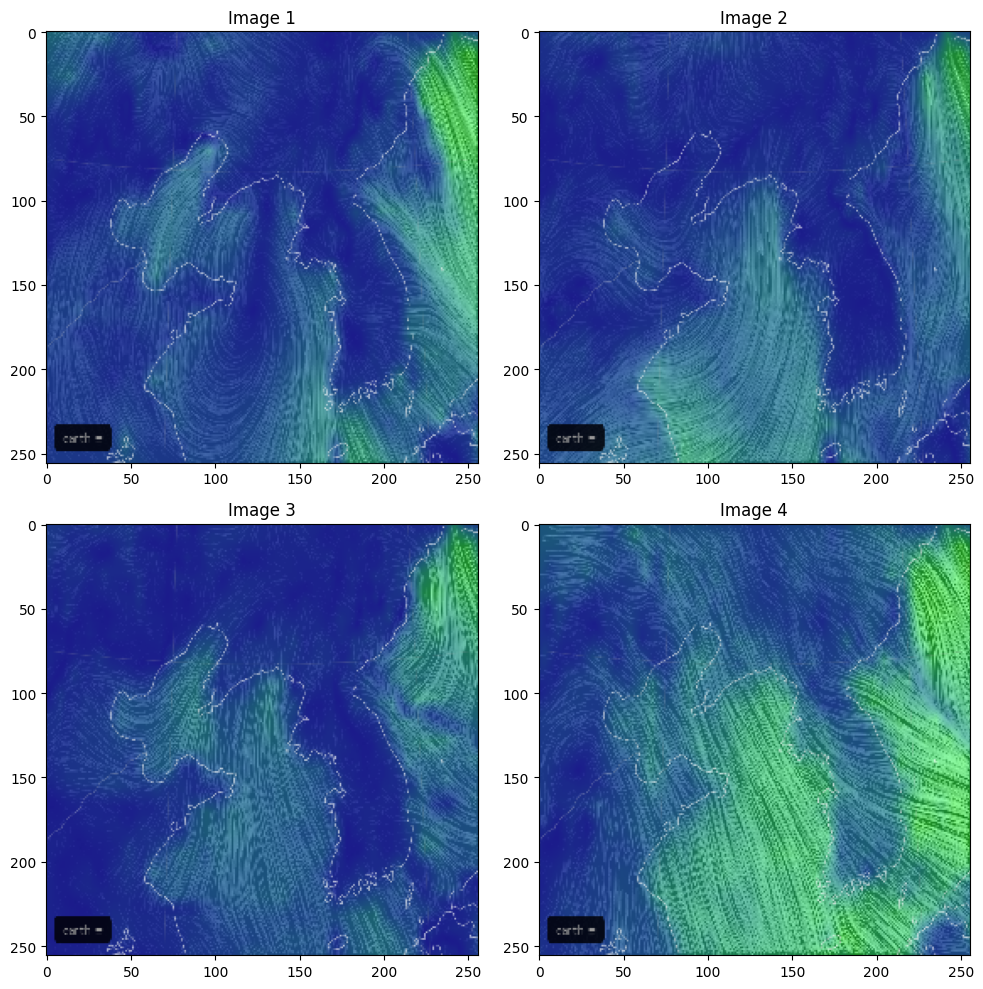

In [116]:
# 새로운 데이터 확인을 위해 다시 시각화
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(X_new[0])
axs[0, 0].set_title('Image 1')

axs[0, 1].imshow(X_new[100])
axs[0, 1].set_title('Image 2')

axs[1, 0].imshow(X_new[200])
axs[1, 0].set_title('Image 3')

axs[1, 1].imshow(X_new[300])
axs[1, 1].set_title('Image 4')

plt.tight_layout()
plt.show()

In [117]:
# 이전보다는 개선되었다는 것을 알 수 있다.
# 모델 정의 및 학습(Dropout을 사용하는 CNN 모델)
input_shape = (256, 256, 3)
output_size = 2

model5 = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(output_size, activation='linear')
])

model5.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model5.summary()

history5 = model5.fit(X_new, y_new, batch_size=32, epochs=15, validation_split=0.2)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 30, 30, 32)      

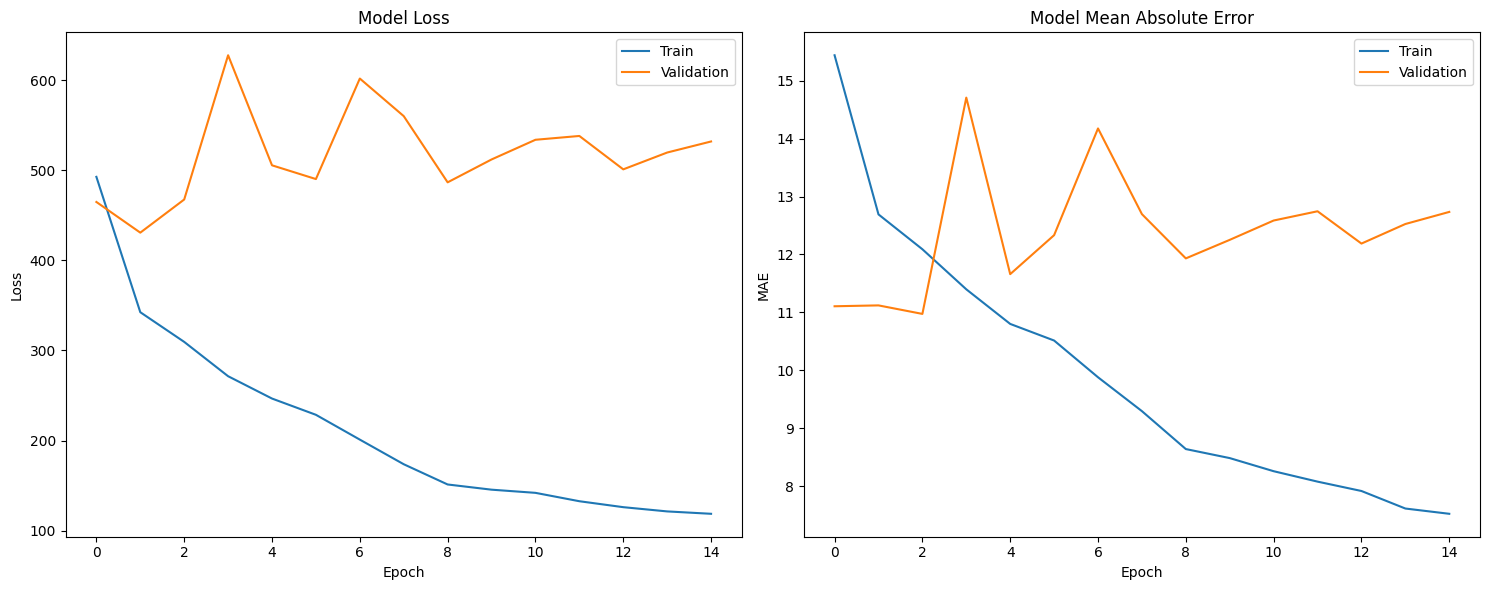

In [118]:
# 학습 곡선 확인
plot_loss_curve(history5)

분석: Dropout의 영향으로 학습 곡선이 매우 불안정한 형태를 띈다는 것 외에는 과적합이 해소된 것 같지 않은 것으로 생각된다. 다른 파라미터와 모델 구조를 시도해본다.

##### 2.2.3. model 6
- input: 현재 바람지도 데이터
- output: 현재 미세먼지, 초미세먼지의 값을 예측
- 특징: 과적합 해소를 위한 다양한 시도의 일환으로 모델의 크기를 더 줄이고, Dropout을 더 강하게 걸어본다.

In [127]:
# 바람지도 배열 데이터 저장
np.save('X_windmap.npy', X)
np.save('y_windmap.npy', y)
np.save('X_new_windmap.npy', X_new)
np.save('y_new_windmap.npy', y_new)

In [3]:
# 바람지도 배열 데이터 불러오기
X = np.load('X_windmap.npy')
y = np.load('y_windmap.npy')
X_new = np.load('X_new_windmap.npy')
y_new = np.load('y_new_windmap.npy')

In [4]:
# 모델 정의 및 학습(모델 변형)
input_shape = (256, 256, 3)
output_size = 2

model6 = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='relu'),
    Dropout(0.5),
    Dense(output_size, activation='linear')
])

model6.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model6.summary()

history6 = model6.fit(X_new, y_new, batch_size=32, epochs=15, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 32)        0

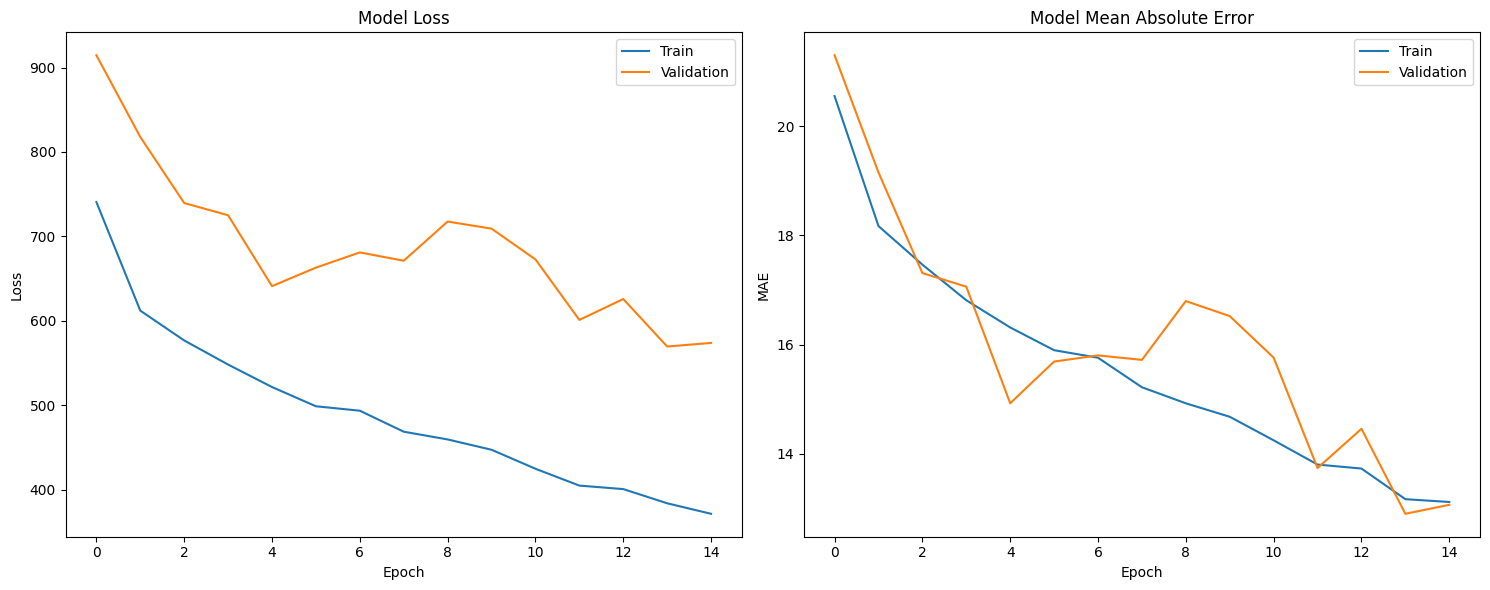

In [6]:
# 학습 곡선 확인
plot_loss_curve(history6)

분석: 학습 곡선의 형태가 과적합이 해소된 것처럼 나타난다! validation과 train 데이터의 loss, mae가 비슷한 경향으로 감소한다. 다른 모델을 다시 시도해본다.

##### 2.2.4. model 7
- input: 현재 바람지도 데이터
- output: 현재 미세먼지, 초미세먼지의 값을 예측
- 특징: 과적합이 나타나지 않았으니, 이번에는 모델 형태 변형과 동시에 EarlyStopping을 걸고 epoch를 늘려서 학습을 진행해본다.

In [8]:
# 과대 적합이 나타나지 않았다! 비슷한 모델 구조로 epoch를 늘려서 학습을 좀 더 진행해보자.
# 모델 정의 및 학습(모델 변형)
input_shape = (256, 256, 3)
output_size = 2
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model7 = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='relu'),
    Dropout(0.5),
    Dense(output_size, activation='linear')
])

model7.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model7.summary()

X_new_train, X_new_val, y_new_train, y_new_val = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

print('train start!')

history7 = model7.fit(
    X_new_train, 
    y_new_train, 
    batch_size=32, 
    epochs=30, 
    validation_data=(X_new_val, y_new_val),
    callbacks=[early_stopping_callback],
    verbose=1
)

test_loss7, test_mae7 = model7.evaluate(X_new_val, y_new_val)
print(f"Test Loss: {test_loss7}, Test MAE: {test_mae7}")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 16)      1168      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        2320      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 16)       

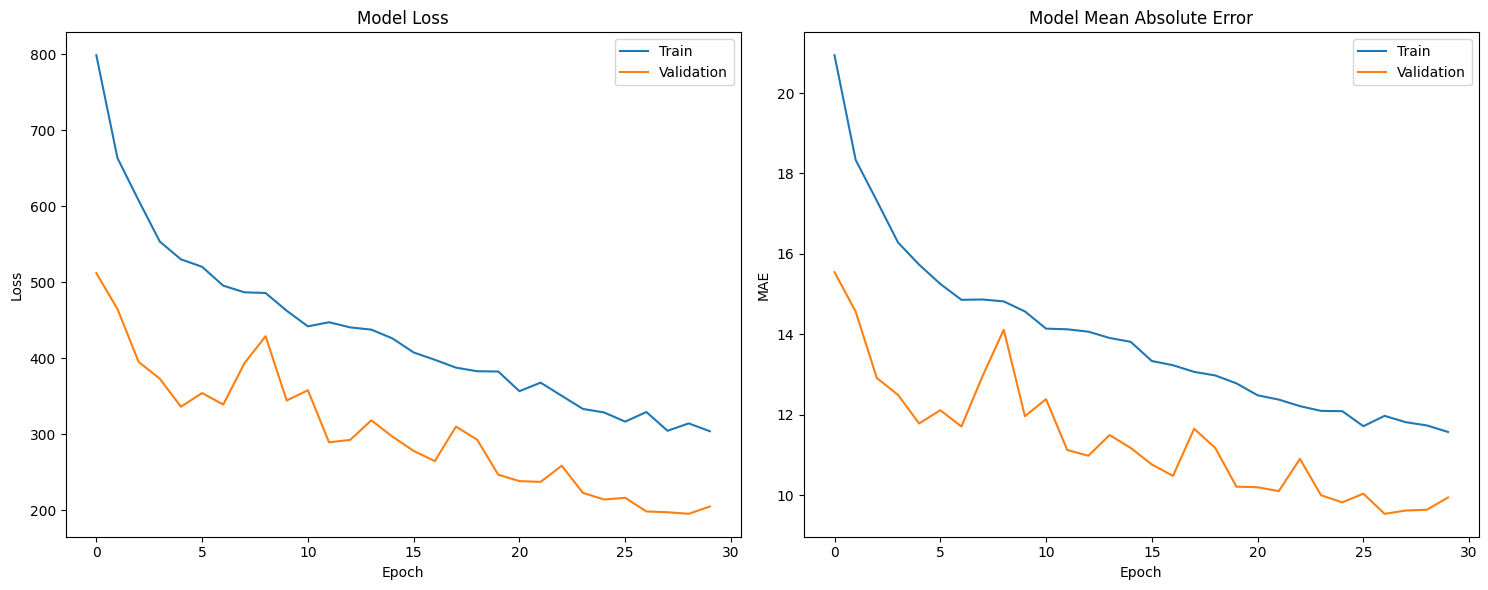

In [9]:
# 학습 곡선 확인
plot_loss_curve(history7)

분석: 역시나 과적합이 나타나지 않는다. 이제 성능 개선을 위해 다양한 모델을 시도해볼 차례인 것으로 생각된다.

##### 2.2.5. model 8
다양한 모델을 시도하여 최적의 성능을 내는 모델을 선정한다.

In [10]:
# 마지막 시도로 다양한 성능 개선을 위한 모델 시도
input_shape = (256, 256, 3)
output_size = 2
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model8 = Sequential([
    Conv2D(8, (4, 4), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Conv2D(16, (4, 4), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(16, activation='relu'),
    Dropout(0.4),
    Dense(8, activation='relu'),
    Dropout(0.4),
    Dense(output_size, activation='linear')
])

model8.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model8.summary()

history8 = model8.fit(
    X_new_train, 
    y_new_train, 
    batch_size=32, 
    epochs=30, 
    validation_data=(X_new_val, y_new_val),
    callbacks=[early_stopping_callback],
    verbose=1
)

test_loss8, test_mae8 = model8.evaluate(X_new_val, y_new_val)
print(f"Test Loss: {test_loss8}, Test MAE: {test_mae8}")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 253, 253, 8)       392       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 126, 126, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 123, 123, 16)      2064      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 61, 61, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 59, 59, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 29, 29, 32)       

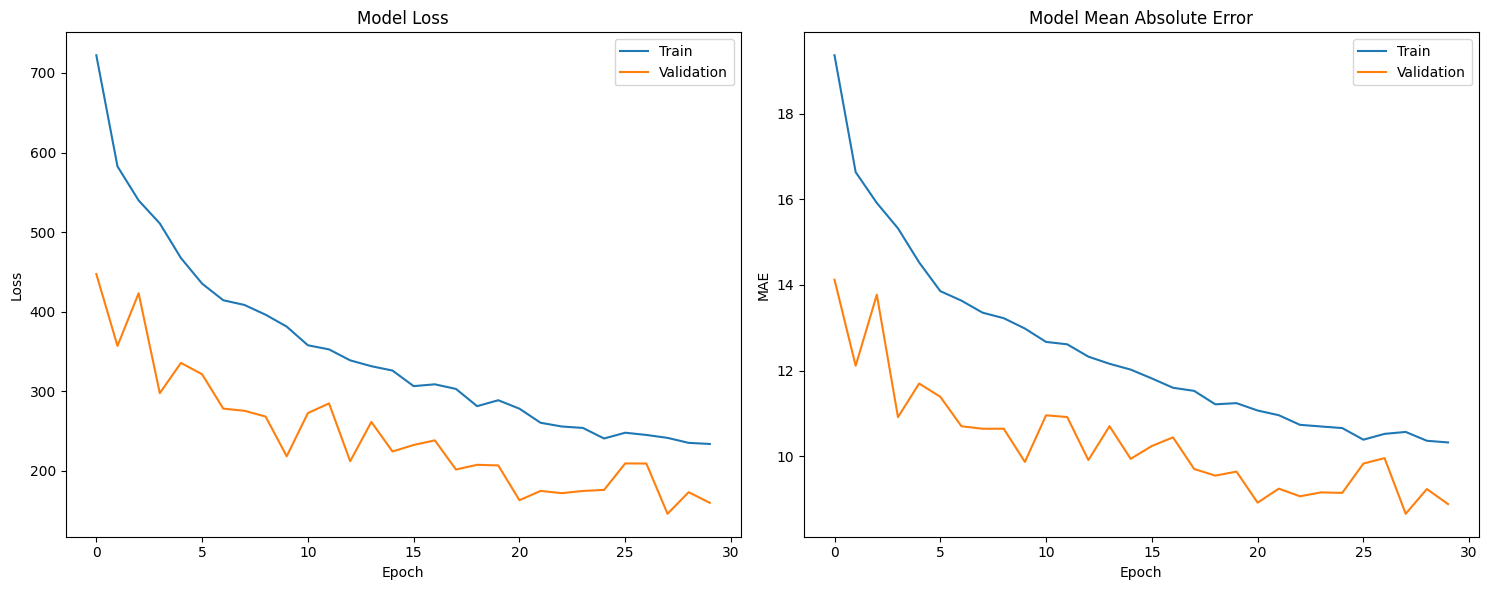

In [11]:
# 학습 곡선 확인
plot_loss_curve(history8)

In [12]:
# 모델 저장
model8.save('model8.h5')

c:\Users\idfor\miniconda3\envs\ML\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


분석: 확실히 바람지도 데이터만 가지고 loss 160.0, mae 8.886의 성능을 내니 바람지도 데이터에 이제 꽤 유의미한 미세먼지 관련 패턴이 있다는 것을 확신할 수 있다. 이제 모델을 합쳐보자.

#### 2.3 최종 모델

##### 2.3.1. final model
- input: 이전 일주일의 기상정보 데이터, CO 데이터, 그리고 현재의 바람지도 데이터
- output: 현재 미세먼지, 초미세먼지의 값을 예측
- 특징: 최종 모델로 선정한 CNN, RNN을 결합한 모델이다. 먼저, 이 모델은 위에서 학습한 model 3처럼 일주일치의 기상정보 데이터, CO 데이터를 통해서 미세먼지를 예측하는 구조를 가진다. 하지만 여기에 바람지도 데이터도 함께 포함하게 된다. 바람지도 데이터는 현재의 것을 활용하게 되며 시계열 데이터와 형태를 맞춰서 RNN을 사용하기 위해 이를 전체 시계열에 동일하게 넣어주게 된다. CNN이 RNN의 각 셀에 존재하게 되는 것이며, 이 때의 CNN은 이미 학습을 진행한 model 8을 가져와서 전이학습과 비슷한 구조로 일부 파라미터를 동결시키고 다시 한번 학습을 진행시킨다. 자세한 구조는 아래의 주석을 참고하라.

In [23]:
# 일주일 단위로 시계열을 자른다.
n_steps = 24*7
X_seq, y_seq = create_sequences(X, y, n_steps)
X_seq, y_seq

(array([[[0.10547667, 0.        , 0.21590909, ..., 0.        ,
          0.        , 0.        ],
         [0.09127789, 0.        , 0.20454545, ..., 0.        ,
          0.        , 0.        ],
         [0.0851927 , 0.        , 0.13636364, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.2515213 , 0.        , 0.23863636, ..., 0.        ,
          0.        , 0.        ],
         [0.23935091, 0.        , 0.20454545, ..., 0.        ,
          0.        , 0.        ],
         [0.23326572, 0.        , 0.11363636, ..., 0.        ,
          0.        , 0.        ]],
 
        [[0.09127789, 0.        , 0.20454545, ..., 0.        ,
          0.        , 0.        ],
         [0.0851927 , 0.        , 0.13636364, ..., 0.        ,
          0.        , 0.        ],
         [0.08924949, 0.        , 0.15909091, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.23935091, 0.        , 0.20454545, ..., 0.        ,
          0.        , 0.

In [19]:
# 바람지도 데이터를 불러온다.
X_windmap = np.load('X_new_windmap.npy')
X_windmap

array([[[[0.10588235, 0.38431373, 0.4392157 ],
         [0.13333334, 0.4117647 , 0.47058824],
         [0.10588235, 0.3764706 , 0.44705883],
         ...,
         [0.10588235, 0.3254902 , 0.48235294],
         [0.10588235, 0.3137255 , 0.4862745 ],
         [0.10588235, 0.30980393, 0.49019608]],

        [[0.15294118, 0.43137255, 0.49019608],
         [0.10588235, 0.38039216, 0.44313726],
         [0.12941177, 0.4       , 0.47058824],
         ...,
         [0.12156863, 0.36078432, 0.4862745 ],
         [0.10588235, 0.3372549 , 0.4745098 ],
         [0.18039216, 0.40784314, 0.5529412 ]],

        [[0.10588235, 0.38039216, 0.44313726],
         [0.11764706, 0.3882353 , 0.45882353],
         [0.10588235, 0.37254903, 0.44705883],
         ...,
         [0.21176471, 0.4745098 , 0.5568628 ],
         [0.10588235, 0.36078432, 0.45882353],
         [0.10588235, 0.3529412 , 0.4627451 ]],

        ...,

        [[0.10588235, 0.21176471, 0.5294118 ],
         [0.10588235, 0.21176471, 0.5294118 ]

In [24]:
# 형태 확인
X_seq.shape, X_windmap.shape

((8592, 168, 55), (8760, 256, 256, 3))

In [25]:
# 형태 통일
X_windmap = X_windmap[168:]
X_windmap.shape

(8592, 256, 256, 3)

In [26]:
# train, test 데이터 분리
X_train_seq, X_test_seq, X_train_windmap, X_test_windmap, y_train_seq, y_test_seq = train_test_split(X_seq, X_windmap, y_seq, test_size=0.2, random_state=42)

In [27]:
# 학습을 진행했던 cnn_model을 가져와서 활용
cnn_model = tf.keras.models.load_model('model8.h5')

In [28]:
# cnn_model의 일부 레이어를 동결
for idx, layer in enumerate(cnn_model.layers):
    if idx>6: break
    layer.trainable = False

# 모델을 정의(Sequential 모델의 구조와 다르게 기존 RNN의 input과 CNN의 Dense 층을 병렬하여 구성)
n_steps = 24*7
input_shape_cnn = (256, 256, 3)
time_series_shape = 55

cnn_input = Input(shape=input_shape_cnn)
cnn_output = cnn_model(cnn_input)
replicated_cnn_output = RepeatVector(n_steps)(cnn_output) # CNN의 output을 시계열 길이만큼 복제
time_series_input = Input(shape=(n_steps, time_series_shape))
combined_input = concatenate([replicated_cnn_output, time_series_input], axis=-1)

rnn = LSTM(50)(combined_input)
output = Dense(2, activation='linear')(rnn)

model_combined1 = Model(inputs=[cnn_input, time_series_input], outputs=output)
model_combined1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model_combined1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_3 (Sequential)   (None, 2)                    437858    ['input_9[0][0]']             
                                                                                                  
 repeat_vector_1 (RepeatVec  (None, 168, 2)               0         ['sequential_3[0][0]']        
 tor)                                                                                             
                                                                                                  
 input_10 (InputLayer)       [(None, 168, 55)]            0         []                      

In [29]:
# 학습을 진행
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_combined1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history_combined1 = model_combined1.fit(
    [X_train_windmap, X_train_seq],
    y_train_seq,                       
    epochs=100,                      
    batch_size=32,                   
    validation_data=(
        [X_test_windmap, X_test_seq],
        y_test_seq
    ),          
    callbacks=[early_stopping_callback],   
    verbose=1 
)

Epoch 1/100
215/215 [==============================] - 42s 185ms/step - loss: 678.5779 - mae: 18.0461 - val_loss: 421.4845 - val_mae: 13.3171
Epoch 2/100
215/215 [==============================] - 40s 186ms/step - loss: 413.2840 - mae: 12.4075 - val_loss: 315.6632 - val_mae: 11.6179
Epoch 3/100
215/215 [==============================] - 36s 168ms/step - loss: 354.7557 - mae: 11.7854 - val_loss: 294.7449 - val_mae: 11.7038
Epoch 4/100
215/215 [==============================] - 38s 177ms/step - loss: 343.5362 - mae: 11.8926 - val_loss: 292.8410 - val_mae: 11.7448
Epoch 5/100
215/215 [==============================] - 38s 175ms/step - loss: 340.1818 - mae: 11.8712 - val_loss: 289.5407 - val_mae: 11.6918
Epoch 6/100
215/215 [==============================] - 38s 175ms/step - loss: 338.0784 - mae: 11.9430 - val_loss: 292.4919 - val_mae: 11.9874
Epoch 7/100
215/215 [==============================] - 38s 178ms/step - loss: 337.7693 - mae: 12.0557 - val_loss: 288.1691 - val_mae: 11.8279
Epoch 

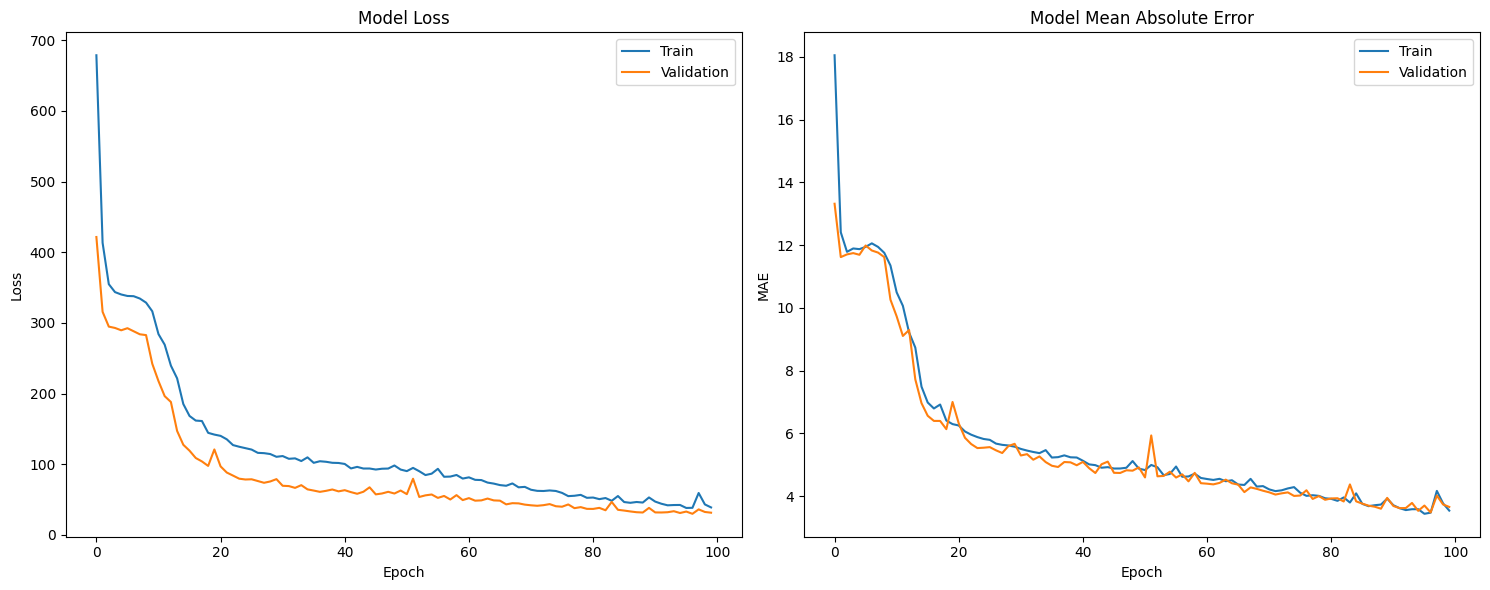

In [32]:
# 학습 곡선 확인
plot_loss_curve(history_combined1)

In [33]:
# 최종 성능 평가
model_combined1.evaluate([X_test_windmap, X_test_seq], y_test_seq)

54/54 [==============================] - 5s 100ms/step - loss: 31.5188 - mae: 3.6601


[31.518779754638672, 3.660099506378174]

In [34]:
# 모델 저장
model_combined1.save('model_combined1.h5')

c:\Users\idfor\miniconda3\envs\ML\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


분석: loss가 31.52, mae가 3.660으로 이전에 비해 조금 개선되었다. 역시 바람지도 데이터가 도움이 되었던 것으로 생각된다.

##### 2.3.2. 최종 분석
1. 프로젝트의 목적

본 프로젝트의 목적은 큰 범위에서 3대 미세먼지의 원인으로 뽑히는 '중국', 'CO 배출', '기상' 데이터를 이용해서 서울의 평균 미세먼지를 종합적으로 예측해보는 모델을 만들어보는 것이었다. 이는 건강을 해치는 미세먼지의 정보를 신속하고 정확하게 알 수 있게 하는 것을 통해 K-SDGs 목표 중에서 목표 9. 산업의 성장과 혁신 활성화 및 사회기반시설 구축, 목표 3. 건강하고 행복한 삶 보장을 이루어 내는 데에 도움을 줄 수 있다. (세부 목표는 중간발표자료 참고) 

본 프로젝트에서 설정한 모델의 구조는 일주일치의 다양한 종합 정보를 받아서 미세먼지의 예측값을 내놓는 구조이다. 이전 미세먼지의 값을 왜 제외하였는지 의문을 품는 사람이 많을 것이다. 이는 본 프로젝트에서 설정한 가정 때문이다. 미세먼지를 결정하는 위의 3가지 요인에 대한 데이터는 비교적 안정적으로 예측 가능한 데이터라는 생각이 든다. 그래서 미래의 이들 수치에 대한 예측은 정확한데에 반해 미세먼지를 결정하는 요인은 다양하여 분석이 어렵다. 그래서 현 시점에서 사용하는 모델은 시뮬레이션에 가까운 구조로 미세먼지를 예측하지만 조금 아쉬움이 있다. 그래서 이번 프로젝트에서는 위의 데이터만 가지고 미세먼지의 데이터를 딱 예측할 수 있게 하여 비교적 가까운 미래의 미세먼지 데이터에 대한 분석도 쉬워질 수 있도록 하고자 했다.
 

2. 프로젝트의 결과

프로젝트의 결과는 성공적이었다. RNN 모델만으로도 좋은 결과를 얻을 수 있었지만, 학습한 CNN 모델까지 통합하여 다시 학습시키니 성능이 조금이나마 개선이 되었다는 사실을 알 수 있었다. 이 과정을 위해서 CNN의 과적합을 해소하고, 모델을 최적화하기 위해 다양한 시도를 하는 등 노력이 가해졌다.

3. 프로젝트의 의의

프로젝트는 크게 두 가지 의의를 갖는다. 먼저, 위에서 말한 미세먼지 예측에 도움을 주는 모델을 학습시켰다. 그리고 중요한 두번째로 미세먼지를 예측하는데 어떤 데이터가 중요한지를 인공지능 모델을 통해서 판단할 수 있었다. 위에서 언급했듯이 바람지도 데이터를 EDA 할때는 정말로 이를 통해 미세먼지를 예측하는데 도움을 줄 수 있는지 의문이 들었다. 하지만 그 데이터만 가지고 모델을 학습시키니 조금 큰 오차이지만 어떤 학습이 되는 형태가 나타나며, 예상보다 비교적 가깝게 예측을 할 수 있다는 사실을 발견했다. 이는 사람이 육안으로 확인하기는 어렵지만 어떤 숨겨진 패턴이 있어서 미세먼지 예측을 가능케 해준다는 것을 의미한다. 즉, 이 숨겨진 패턴을 인공지능 모델이 찾아낸 것이다. 인공지능이 어떤 패턴을 찾았는지 알아내는 것은 블랙 박스지만 모델을 통해 패턴이 존재한다는 사실 자체는 알 수 있었다.

4. 프로젝트의 한계

프로젝트 과정을 보면 알 수 있지만 본 프로젝트에서는 리소스의 한계로 현재의 바람지도 사진을 복제만 했을 뿐 시계열 데이터의 형태로 이전 시간의 바람지도 데이터를 넣지 못했다. 이를 해결하면 구체적인 바람의 흐름, 시간에 따른 변화 등을 알 수 있어서 성능 향상에 도움을 줄 수 있을 터인데 조금 아쉽다. 또한 본 프로젝트에서는 큰 범위의 데이터를 사용하고자 넓은 지역의 평균 미세먼지를 사용했다. 이를 조금 더 좁은 범위에 대해 더 많은 데이터로 예측하는 모델을 만들 수 있을 것이라고 생각한다.